<a href="https://colab.research.google.com/github/Omar-Saeed-OASS/Digit-Classifier-Deep-Learning-Model/blob/main/Digit_Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries:

In [1]:
# Import libraries:

import torch
from torch import nn

# Torch vision:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# DataLoader:
from torch.utils.data import DataLoader

# Matplotlib:
import matplotlib.pyplot as plt

# Timeit:
import timeit

# Path
from pathlib import Path

# Download the Datasets:

In [2]:
# Download the MNIST handwritten digits dataset:

PATH = "/content"

# Training dataset
train = torchvision.datasets.MNIST(
    root=PATH,
    download=True,
    train=True,
    transform=ToTensor(),
)

# Testing dataset
test = torchvision.datasets.MNIST(
    root=PATH,
    download=True,
    train=False,
    transform=ToTensor()
)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 908kB/s] 


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.79MB/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



# Plot Samples from The Dataset:

In [3]:
# Digits classes
digit_classes = train.classes
digit_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

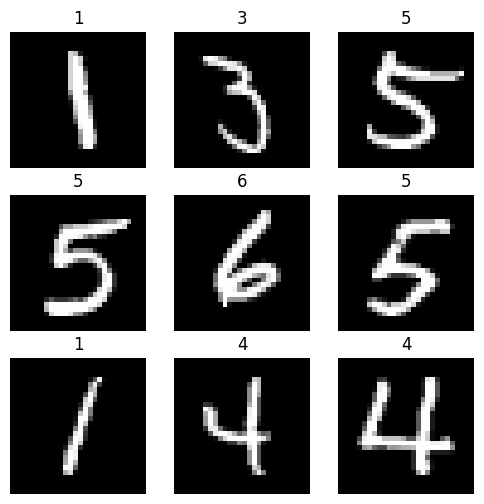

In [4]:
# Plot random digits in gray scale:

fig = plt.figure(figsize=(6, 6))

# Grid deminsions
rows = 3
colns = 3

for i in range(1, rows * colns + 1):
  img_id = torch.randint(0, len(train), size=[1]).item() # random index
  img, lbl = train[img_id]
  fig.add_subplot(rows, colns, i)
  plt.axis(False)
  plt.title(lbl)
  plt.imshow(img.squeeze(), cmap="gray")

# Load the Data Using DataLoader:

In [5]:
# Batch size hyperparameter:

BATCH_SIZE = 32

# Convert the datasets into mini-batches:

train_batch = DataLoader(train,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

test_batch = DataLoader(test,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

In [6]:
print(f"1-Training batch size: {len(train_batch)} \n2-Testing batch size: {len(test_batch)}")

1-Training batch size: 1875 
2-Testing batch size: 313


In [7]:
# Check the training dataloader:

train_batch_features, train_batch_labels = next(iter(train_batch))
train_batch_features.shape, train_batch_labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# Build the DeepLearning Model:

In [8]:
# Create the model:

class Digit_Classifier_Model(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    """Forward Pass"""
    return self.layers(x)


# Setup the Model and Device Agnostic Code:

In [9]:
# Setup the model and device agnostic code:

device = "cuda" if torch.cuda.is_available() else "cpu"
Digit_Classifier = Digit_Classifier_Model(input_shape=784, output_shape=len(digit_classes), hidden_units=10)
Digit_Classifier.to(device)
print(f"The model is on: {device}")

The model is on: cuda


# Optimizer and Loss Functions:

In [10]:
# Setup loss function and optimizer:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Digit_Classifier.parameters(), lr=0.001)

# Training and Testing Loop:

In [11]:
# Training and testing loop:

torch.manual_seed(42)
epochs = 20

train_loss_rate = []
test_loss_rate = []
training_time = []

# Creat training and testing loop:
for epoch in range(epochs):

  start_timer = timeit.default_timer()

  average_train_loss = 0.0

  # Loop through the batches
  for batch, (X, y) in enumerate(train_batch):

    # Train mode
    Digit_Classifier.train()

    # Forward pass
    train_pred = Digit_Classifier(X.to(device))

    # Calculate the loss
    train_loss = loss_fn(train_pred, y.to(device))

    average_train_loss += train_loss.item() # add the loss per epoch through the batch

    # Optimizer Zero_grad
    optimizer.zero_grad()

    # Back propagation
    train_loss.backward()

    # Optimizer step
    optimizer.step()

  # Divide total train loss by length of training batch (average loss per batch per the epoch)
  average_train_loss /= len(train_batch)


  # Testing loop:

  average_test_loss = 0.0

  Digit_Classifier.eval()
  with torch.inference_mode():

    # Loop through test dataset
    for X, y in test_batch:

      test_pred = Digit_Classifier(X.to(device))

      test_loss = loss_fn(test_pred, y.to(device))

      average_test_loss += test_loss.item()

    average_test_loss /= len(test_batch)

    end_timer = timeit.default_timer()

    epoch_training_duration = end_timer - start_timer

  print(f"Epoch: {epoch + 1} | Train loss: {average_train_loss:.3f} | Test loss: {average_test_loss:.3f} | Epoch Time: {epoch_training_duration:.2f} sec")

  # Append the results
  train_loss_rate.append(average_train_loss)
  test_loss_rate.append(average_test_loss)
  training_time.append(epoch_training_duration)


Epoch: 1 | Train loss: 0.767 | Test loss: 0.438 | Epoch Time: 10.99 sec
Epoch: 2 | Train loss: 0.392 | Test loss: 0.361 | Epoch Time: 10.43 sec
Epoch: 3 | Train loss: 0.326 | Test loss: 0.319 | Epoch Time: 10.38 sec
Epoch: 4 | Train loss: 0.293 | Test loss: 0.290 | Epoch Time: 10.06 sec
Epoch: 5 | Train loss: 0.271 | Test loss: 0.272 | Epoch Time: 14.75 sec
Epoch: 6 | Train loss: 0.253 | Test loss: 0.260 | Epoch Time: 10.21 sec
Epoch: 7 | Train loss: 0.240 | Test loss: 0.251 | Epoch Time: 10.01 sec
Epoch: 8 | Train loss: 0.231 | Test loss: 0.244 | Epoch Time: 10.40 sec
Epoch: 9 | Train loss: 0.223 | Test loss: 0.238 | Epoch Time: 10.33 sec
Epoch: 10 | Train loss: 0.217 | Test loss: 0.233 | Epoch Time: 10.55 sec
Epoch: 11 | Train loss: 0.212 | Test loss: 0.229 | Epoch Time: 10.49 sec
Epoch: 12 | Train loss: 0.207 | Test loss: 0.227 | Epoch Time: 10.79 sec
Epoch: 13 | Train loss: 0.203 | Test loss: 0.225 | Epoch Time: 10.02 sec
Epoch: 14 | Train loss: 0.199 | Test loss: 0.224 | Epoch Tim

# Plot the Train and Test Loss through the Epochs:

<ipython-input-19-d262624bc4bf>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


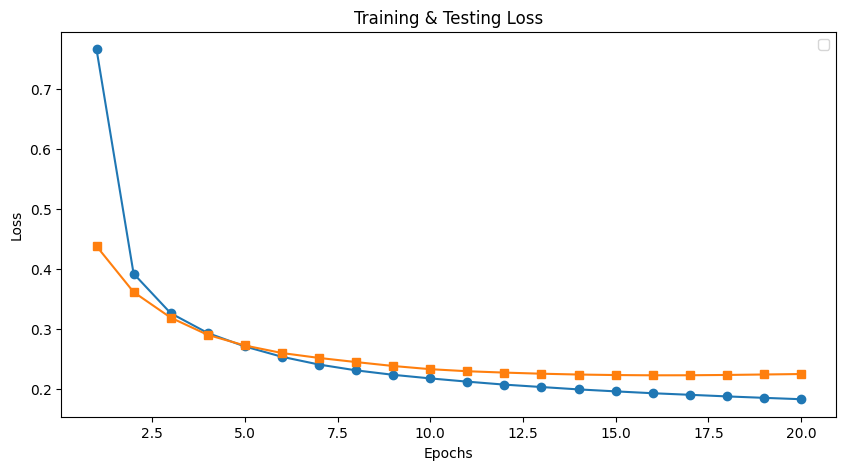

In [19]:
# Plot the Training and Testing Loss

epochs = range(1, 21)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_rate, marker="o")
plt.plot(epochs, test_loss_rate, marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss")
plt.legend(loc="upper right")
plt.show()


# Save the model:


In [13]:
# Saving the model:

MODEL_NAME = "Digit_Classifier_Model_state_dict.pth"
DIR = Path("Models")
DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = DIR/MODEL_NAME # Save directory
#torch.save(obj=Digit_Classifier.state_dict(), f=MODEL_SAVE_PATH) # Save the model parameters (state_dict())